In [1]:
import numpy as np
import scipy
import tensorflow as tf
import numpy
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from csv import reader, excel_tab
from os import listdir
import copy
import math

class JsrtImage(object):
    """ JSRTImage object provides the image and its descriptions in a bundled format. Descriptions for the image include
    filename, nodule size [mm], degree of subtlety, x and y coordinates of the nodule location, age, sex, malignant
    or benign, anatomic location, and diagnosis.

    """
    def __init__(self):
        self.image = None
        self.image_path = None
        self.image_height = None
        self.image_width = None
        self._image_type = None
        self._malignant_or_benign = None
        self._nodule_size = None
        self._degree_of_subtlety = None
        self._x_coordinate = -1
        self._y_coordinate = -1
        self._diagnosis = None
        self._age = None
        self._sex = None
        self._position = None

    def load_image(self, image, height, width, x, y):
        self.image = image
        self.image_height = height
        self.image_width = width
        self._x_coordinate = x
        self._y_coordinate = y
        return self

    def load_from_file(self, path):
        """ Image is of size 2048x2048 in gray scale stored in 16 bit unsigned int in big endian format. """
        self.image_path = path
        raw_image = np.fromfile(self.image_path, dtype=">i2").reshape((2048, 2048))
        raw_image.shape = (2048, 2048)
        self.image = raw_image
        self.image_height = 2048
        self.image_width = 2048
        return self

    @property
    def subtlety(self):
        return self._degree_of_subtlety

    @property
    def diagnosis(self):
        return self._diagnosis

    @property
    def nodule_size(self):
        return self._nodule_size

    @property
    def x(self):
        return self._x_coordinate

    @property
    def y(self):
        return self._y_coordinate

    @property
    def image_type(self):
        if self._image_type is None:
            if "JPCLN" in self.image_path:
                self._image_type = "has nodule"
            else:
                self._image_type = "non-nodule"
        return self._image_type

    @image_type.setter
    def image_type(self, value):
        self._image_type = value

    def display(self, opacity=0.1, nodule_marking=True):
        # Spectral yellow color at a range 0.5 is used.
        # https://matplotlib.org/mpl_examples/color/colormaps_reference_02.png
        if nodule_marking is True:
            cmap = cm.get_cmap('Spectral')
            rgba = cmap(0.5)
            # CT image is in gray scale.
            plt.imshow(self.image, cmap=plt.get_cmap('gray'))
            # We plot a circle at x, y of size 500 with opacity 0.1 and color rgba=cmap(0.5) on Spectral
            plt.scatter([self._x_coordinate], [self._y_coordinate], s=500, c=rgba, alpha=opacity)
            plt.show()
        else:
            plt.imshow(self.image, cmap=plt.get_cmap('gray'))
            plt.show()
        return self

    def add_description(self, data, has_nodule=False):
        """ This function adds additional details to the JsrtImage object.

        Args:
            data       (list): data is a list of the form [filename, degree of subtlety, nodule size [mm], age, sex,
                               x coordinate of the nodule, y coordinate of the nodule, pathology, position, diagnosis]
                               for images with nodules and [filename, age, sex, diagnosis("non-nodule")] for non-nodule
                               images respectively.
            has_nodule (bool): True for images with nodules and False for images without nodules.

        """
        if has_nodule is True:
            self._image_type = "has nodule"
            self._degree_of_subtlety = data[1]
            self._nodule_size = int(data[2])
            self._age = int(data[3] if data[3] != "?" else 0)
            self._sex = str(data[4])
            self._x_coordinate = int(data[5])
            self._y_coordinate = int(data[6])
            self._malignant_or_benign = str(data[7])
            self._position = str(data[8])
            self._diagnosis = str(data[9])

        elif has_nodule is False:
            self._image_type = "non-nodule"
            self._age = data[1]
            self._sex = data[2]
            self._x_coordinate = -1
            self._y_coordinate = -1
        return self

    def get_all_details(self):
        full_details = []
        if self._image_type == "has nodule":
            full_details.append(self.image_path)
            full_details.append(self._age)
            full_details.append(self._sex)
            full_details.append(self._x_coordinate)
            full_details.append(self._y_coordinate)
            full_details.append(self._degree_of_subtlety)
            full_details.append(self._nodule_size)
            full_details.append(self._malignant_or_benign)
            full_details.append(self._position)
            full_details.append(self._diagnosis)

        elif self._image_type == "non-nodule":
            full_details.append(self.image_path)
            full_details.append(self._age)
            full_details.append(self._sex)
            full_details.append(self._x_coordinate)
            full_details.append(self._y_coordinate)
        return full_details

    def horizontal_reflection(self):
        """ This function does a horizontal flip of the image and changes the x coordinate of the lung nodule
        if present. Also the function changes the doctors diagnosis position from "left" to "right" or vice-versa
        similar to the flip.

        """
        # np.fliplr - Flips array in the left/right direction.
        self.image = np.fliplr(self.image)
        if self._image_type == "has nodule":
            # New position of the lung nodule, after reflection
            self._x_coordinate = self.image_width - self._x_coordinate
            if "left" in self._position:
                self._position = self._position.replace("left", "right")
            elif "l." in self._position:
                self._position = self._position.replace("l.", "r.")
            elif "right" in self._position:
                self._position = self._position.replace("right", "left")
            elif "r." in self._position:
                self._position = self._position.replace("r.", "l.")
        return self

    def rotate(self, degrees):
        """ This function does a counter clockwise rotation of image to the amount of degrees given. It uses
        scipy.ndimage's rotate function to rotate the image. The function also adjusts the position of the x and
        y coordinate of the nodule correctly.

        HACK: get_rotate_mat function is actually the code from scipy.ndimage.rotate function to get the rotation matrix
        that was used for image transformation. This helps to get the new coordinates of the lung nodule in the
        rotated image.

        https://github.com/scipy/scipy/blob/bcbb9381bc5cf7868b2f96c59302ef04faafa6d9/scipy/ndimage/interpolation.py#L658-784

        Args:
            degrees (int): rotation angle in degrees. If a negative value is given, then clockwise rotation occurs.

        Returns:
            None
            ( Existing image is rotated by degrees amount and new coordinates of lung nodule are added. )

        """
        image_rotated = ndimage.rotate(self.image, degrees, mode="nearest", reshape=False)
        self.image = image_rotated[:2048, :2048]
        if self._image_type == "has nodule":
            def get_rotate_mat(shape, angle):
                m11 = math.cos(angle)
                m12 = math.sin(angle)
                m21 = -math.sin(angle)
                m22 = math.cos(angle)
                matrix = np.array([[m11, m12], [m21, m22]], dtype=np.float64)
                iy = shape[0]
                ix = shape[1]
                oy = shape[0]
                ox = shape[1]
                offset = np.zeros((2,), dtype=np.float64)
                offset[0] = float(oy) / 2.0 - 0.5
                offset[1] = float(ox) / 2.0 - 0.5
                offset = np.dot(matrix, offset)
                tmp = np.zeros((2,), dtype=np.float64)
                tmp[0] = float(iy) / 2.0 - 0.5
                tmp[1] = float(ix) / 2.0 - 0.5
                offset = tmp - offset
                return offset, matrix

            off, mat = get_rotate_mat(self.image.shape, np.deg2rad(degrees))
            a = np.dot(mat, [[self._x_coordinate], [self._y_coordinate]])
            self._x_coordinate = a[0][0] + off[0]
            self._y_coordinate = a[1][0] + off[1]
        return self

    def crop(self, size, x, y):
        """ This function obtains a cropped image of `size`. The image is cropped as a square with location x and y
        denoting the center of the cropped image. So the edge points of the cropped image in actual image is
        top left    : (x - size/2, y - size/2)
        top right   : (x + size/2, y - size/2)
        bottom left : (x - size/2, y + size/2)
        bottom right: (x + size/2, y + size/2)

        Args:
            size (int): glimpse/cropped image size
            x    (int): x coordinate of the crop location's (center/middle) position.
            y    (int): y coordinate of the crop location's (center/middle) position.

        Returns:
            crop (array): numpy array of (size, size)

        """
        if x < 0 or y < 0 or size < 0:
            raise ValueError("Crop: Invalid x, y coordinates or size")
        left_offset = 0
        right_offset = size
        top_offset = 0
        bottom_offset = size
        half_size = size // 2

        left_x = x - half_size
        top_y = y - half_size

        if x - half_size < 0:
            left_offset = half_size - x
            left_x = 0
        if y - half_size < 0:
            top_offset = half_size - y
            top_y = 0
        if x + half_size > 2048:
            right_offset = half_size + 2048 - x
        if y + half_size > 2048:
            bottom_offset = half_size + 2048 - y

        crop = np.zeros((size, size), dtype=">i2")
        width = right_offset - left_offset
        height = bottom_offset - top_offset

        crop[top_offset: bottom_offset, left_offset: right_offset] = \
            self.image[top_y: top_y + height, left_x: left_x + width]
        return crop

    def down_sample(self, ratio):
        """ This function down samples the image by `ratio` factor. Image is re-sampled by a factor of
        `ratio` with nearest interpolation.

        Args:
            ratio (float): ratio to which image is to be reduced.

        Returns:
            new_image (array): image
        """
        # order 0 nearest interpolation
        # order 1 bilinear interpolation
        new_image = ndimage.zoom(self.image, ratio, order=0)
        return new_image


class Jsrt(object):
    """ Jsrt is a model to fetch all the images and augment them."""

    def __init__(self):
        self._images_dir = None
        self._has_nodule_image_list = None
        self._non_nodule_image_list = None
        self.test_dataset = None
        self.valid_dataset = None
        self.train_dataset = None

    def load_images(self, images_path):
        self._images_dir = images_path
        self.__get_images_list()
        self.add_descriptions_to_image()
        return self

    def __get_images_list(self):
        images_list = [f for f in listdir(self._images_dir) if not f.startswith('.')]
        _has_nodule_files = []
        _non_nodule_files = []
        # Non-nodule and has-nodule filename are separated based on filename.
        for filename in images_list:
            if "JPCLN" in filename:
                _has_nodule_files.append(filename)
            else:
                _non_nodule_files.append(filename)
        # Image objects are stored as list on _has_nodule_image_list and _non_nodule_image_list
        self._has_nodule_image_list = self._load_images_from_file(_has_nodule_files, self._images_dir)
        self._non_nodule_image_list = self._load_images_from_file(_non_nodule_files, self._images_dir)
        return self

    @staticmethod
    def _load_images_from_file(filenames, directory):
        """ This function load images (not image) located at directory/filename and creates an image object from it.
        Args:
            filenames (list): a list of names of the image files.
            directory  (str): path to the directory/folder where all images are present
        Returns:
            a list of JsrtImage objects

        """
        images_list = []
        for image_name in filenames:
            img = JsrtImage()
            img.load_from_file(directory + image_name)
            images_list.append(img)
        return images_list

    def clean_csv_file(self, file_path, file_type):
        """ This function cleans the csv data present along with the image file. The data is removed of inappropriate
        splits and combined into a 10 element list for images with nodules and 4 element list for images without
        nodules.

        csv content is formatted into [filename, degree of subtlety, nodule size [mm], age, sex, x coordinate
        of the nodule, y coordinate of the nodule, pathology, position, diagnosis] format for images with nodules
        and [filename, age, sex, diagnosis("non-nodule")] format for non-nodule images respectively.

        Args:
            file_path (str) : Path to the CSV file for nodule and non-nodule images.
            file_type (str) : If file_path is to nodule images, then file_type is "nodule csv" and if file_path is to
                              non-nodule images, then file_type is "non nodule csv".

        Returns:
            csv_data (dict): csv_data returns a dict of the form { 'filename' : 'filename' image's csv data }.

            Example:
                { "./All247images/JPCNN010.IMG" : ['JPCNN010.IMG', '54', 'male', 'non-nodule'] }

        """
        csv_data = {}
        if file_type == "nodule csv":
            with open(file_path, "rU") as csv_file:
                content = reader(csv_file, dialect=excel_tab)
                for row in content:
                    if len(row) != 0:
                        row[8:10] = [" ".join(row[8:10])]
                        row[9:] = [" ".join(row[9:])]
                        csv_data[self._images_dir + row[0]] = row
            return csv_data
        elif file_type == "non nodule csv":
            with open(file_path, "rU") as csv_file:
                content = reader(csv_file, dialect=excel_tab)
                for row in content:
                    if len(row) != 0:
                        row = row[0].split(" ")
                        new_row = []
                        new_row.extend([row[0], row[1], row[3], row[len(row) - 1]])
                        csv_data[self._images_dir + new_row[0]] = new_row
            return csv_data
        else:
            return csv_data

    def add_descriptions_to_image(self):
        """ This function fetches the descriptions of the images present in the csv file and adds them
            to the JsrtImage object.
        """
        csv_data = self.clean_csv_file("Clinical_Information/CLNDAT_EN.txt", "nodule csv")

        for image in self._has_nodule_image_list:
            image.add_description(csv_data[image.image_path], has_nodule=True)

        csv_data = self.clean_csv_file("Clinical_Information/CNNDAT_EN.TXT", "non nodule csv")

        for image in self._non_nodule_image_list:
            image.add_description(csv_data[image.image_path], has_nodule=False)

    def get_images(self, has_nodule=True, num_of_images=1):
        """ This function gives "num_of_images" number of JsrtImage objects in a list. The objects can be either all
        image with nodules or non-nodules.

        Args:
            has_nodule   (bool): Defaults to True. Images with the nodules are selected when it is set to True and
                                images without nodules are selected when it is set to False.
            num_of_images (int): Defaults to 1. The required number of images is given.

        Returns:
            a list of JsrtImage objects. Total objects will be num_of_images.

        """
        if has_nodule is True:
            if len(self._has_nodule_image_list) < num_of_images:
                return -1
            return self._has_nodule_image_list[:num_of_images]
        else:
            if len(self._has_nodule_image_list) < num_of_images:
                return -1
            return self._non_nodule_image_list[:num_of_images]

    @staticmethod
    def save_images(dataset, filename):
        """ This function saves the jsrt image dataset into TFRecords format. Currently the function stores only the
        image, its height, width, x and y coordinates of the nodule.

        Args:
            dataset (list): A list of JsrtImage objects to be stored in tfrecords format.
            filename (str): name of the tfrecords file.

        Examples:
            jsrtdata = Jsrt().read_images("./All247images/")
            train_images = jsrtdata.get_images(num_of_images=50)
            jsrtdata.save_images(train_images, "train_images.tfrecords")

        """
        if dataset is None:
            raise ValueError('None obtained as dataset value')

        writer = tf.python_io.TFRecordWriter(filename)

        def _bytes_feature(value):
            return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

        def _int64_feature(value):
            return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

        for jsrtimage in dataset:
            img = jsrtimage.image.tostring()
            height = jsrtimage.image_height
            width = jsrtimage.image_width
            x = jsrtimage.x
            y = jsrtimage.y

            example = tf.train.Example(features=tf.train.Features(feature={
                'height': _int64_feature(height),
                'width': _int64_feature(width),
                'x': _int64_feature(x),
                'y': _int64_feature(y),
                'image': _bytes_feature(img)}))

            writer.write(example.SerializeToString())
        writer.close()

    def save_test_dataset(self, filename):
        self.save_images(self.test_dataset, filename)

    def save_train_dataset(self, filename):
        self.save_images(self.train_dataset, filename)

    def save_valid_dataset(self, filename):
        self.save_images(self.valid_dataset, filename)

    @staticmethod
    def read_images(filename):
        """ This function reads the JsrtImage objects stored in TFrecords file. Currently function only reads the
        image, its height, width, x and y coordinates of the nodule.

        Args:
            filename (str): Path to the tfrecords file

        Returns:
            jsrt_image_list (list): A list of JsrtImage objects having image, height, width, x and y coordinate set up.

        Examples:
            jsrtdata = Jsrt().load_images("./All247images/")
            save_pic = jsrtdata.get_images(num_of_images=1)
            jsrtdata.save_images(save_pic, "test.tfrecords")

            read_pic = jsrtdata.read_images("test.tfrecords")

            print np.allclose(save_pic[0].image, read_pic[0].image)
            if save_pic[0].image_height == read_pic[0].image_height: print "True"
            if save_pic[0].image_width == read_pic[0].image_width: print "True"
            if save_pic[0].x == read_pic[0].x: print "True"
            if save_pic[0].y == read_pic[0].y: print "True"

            You should get 5 True statements as result which confirms that values are same.

        """
        records = tf.python_io.tf_record_iterator(path=filename)
        jsrt_image_list = []
        for string_record in records:
            example = tf.train.Example()
            example.ParseFromString(string_record)
            height = int(example.features.feature['height']
                         .int64_list
                         .value[0])

            width = int(example.features.feature['width']
                        .int64_list
                        .value[0])
            x = int(example.features.feature['x'].int64_list.value[0])
            y = int(example.features.feature['y'].int64_list.value[0])
            img_string = (example.features.feature['image']
                          .bytes_list
                          .value[0])
            image = np.fromstring(img_string, dtype=">i2").reshape((height, width))
            image.shape = (height, width)
            img = JsrtImage()
            img.load_image(image, height, width, x, y)
            jsrt_image_list.append(img)
        return jsrt_image_list

    def read_test_dataset(self, filename):
        self.test_dataset = self.read_images(filename)

    def read_train_dataset(self, filename):
        self.train_dataset = self.read_images(filename)

    def read_valid_dataset(self, filename):
        self.valid_dataset = self.read_images(filename)

    @staticmethod
    def horizontally_reflect_images(image_list):
        """ This function does a horizontal flip of the images present in the image_list given and also changes
        the x coordinate of the lung nodule in the image appropriately (if present).

        See Also: JsrtImage.horizontal_reflection

        Args:
            image_list (list): A list of JsrtImage objects.

        Returns:
            new_image_list (list): A list of JsrtImage objects that are horizontally flipped.

        """
        new_image_list = []
        for image in image_list:
            new_image = copy.copy(image)
            new_image.horizontal_reflection()
            new_image_list.append(new_image)
        return new_image_list

    @staticmethod
    def rotate_image(image_list, rotate_angles):
        """ This function does a rotation of the images present in the image_list with all angles given in rotate_angles
        and it also changes the x coordinate and y coordinate of the lung nodule in the image appropriately.

        See Also: JsrtImage.rotate

        Args:
        image_list (list): A list of all JsrtImage objects.
        rotate_angles (list): A list of angles through which images in `image_list` are to be rotated.

        Returns:
            rotated_images_list (list): It is a list consisting of list of images rotated in given angle.
            Example:
                rotate_image([JsrtImage objects], [1, 2, -3]) # rotate by 1°(anti-clock), 2°(anti-clock), 3°(clockwise)
                [[JsrtImage objects rotated by 1°],[JsrtImage objects rotated by 2°],[JsrtImage objects rotated by -3°]]

        """
        rotated_images_list = []
        for angle in rotate_angles:
            rotated_images_on_each_angle = []
            for image in image_list:
                new_image = copy.copy(image)
                new_image.rotate(angle)
                rotated_images_on_each_angle.append(new_image)
            rotated_images_list.append(rotated_images_on_each_angle)
        return rotated_images_list

    def augment_images(self, horizontal_reflection=True, rotate=True, rotate_angles=[1, 2]):
        """ This function attempts to augment Jsrt images (to increase the dataset) by applying a number of image
        transformations.
            1. Horizontal reflection. To do horizontal refection of the non-nodule and has-nodules images loaded
                pass horizontal_reflection parameter as "True".
            2. Rotation. To do rotation of the non-nodule and has-nodule images loaded, pass the parameter "rotate" as
                True and mention the rotation angles in rotate_angles list.

        Args:
            horizontal_reflection (bool): Defaults to True. Function does horizontal reflection over the images stored
            in _non_nodule_image_list and _has_nodule_image_list and adds the new images to them.
            See Also: horizontally_reflect_images

            rotate (bool): Defaults to True. Function does the rotation of the image stored in _non_nodule_image_list
            and _has_nodule_image_list and adds the new images to them.

            rotate_angles (list): Defaults to [1, 2]. The angles (in degrees) through which images in
            _non_nodule_image_list and _has_nodule_image_list will be rotated. A positive degree means counter-clockwise
            rotation. Default rotation angles are 1° and 2°.

        """
        if horizontal_reflection is True:
            new_non_nodule_image_list = self.horizontally_reflect_images(self._non_nodule_image_list)
            self._non_nodule_image_list += new_non_nodule_image_list
            new_has_nodule_image_list = self.horizontally_reflect_images(self._has_nodule_image_list)
            self._has_nodule_image_list += new_has_nodule_image_list
        if rotate is True:
            rotated_images_list = self.rotate_image(self._non_nodule_image_list, rotate_angles=rotate_angles)
            for images in rotated_images_list:
                self._non_nodule_image_list += images
            rotated_images_list = self.rotate_image(self._has_nodule_image_list, rotate_angles=rotate_angles)
            for images in rotated_images_list:
                self._has_nodule_image_list += images
    


Programme pour parser le dataset JSRT et augumenter le nombre d'images ; lien github : https://github.com/harishanand95/jsrt-parser

In [2]:
jsrtdata = Jsrt().load_images("./All247images/")

C:\Users\ismail1\Anaconda3\lib\site-packages\ipykernel_launcher.py:359: DeprecationWarning: 'U' mode is deprecated
C:\Users\ismail1\Anaconda3\lib\site-packages\ipykernel_launcher.py:368: DeprecationWarning: 'U' mode is deprecated


In [3]:
jsrtdata.augment_images(horizontal_reflection=True, rotate=True, rotate_angles=[1, 2])

non-nodule
2048
2048


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


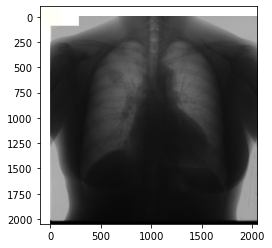

In [4]:
'''TEST'''
img = JsrtImage()
img.load_from_file("./All247images/JPCLN010.IMG")
img.add_description(['JPCLN010.IMG', '54', 'male', 'non-nodule'], has_nodule=False)
print (img.image_type)
print(img.image_width) 
print (img.image_height)
img.display()


In [5]:
len(jsrtdata._non_nodule_image_list)

558

In [6]:
len(jsrtdata._has_nodule_image_list)

918

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


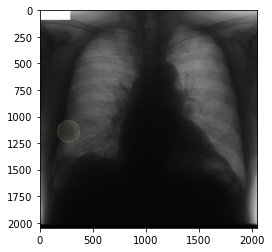

has nodule
268
1136


,image_path,_age,_sex,_x_coordinate,_y_coordinate,_degree_of_subtlety,_nodule_size,_malignant_or_benign,_position,_diagnosis
0,./All247images/JPCNN001.IMG,30,female,-1.000000,-1.000000,None,NaN,None,None,None
1,./All247images/JPCNN002.IMG,62,male,-1.000000,-1.000000,None,NaN,None,None,None
2,./All247images/JPCNN003.IMG,70,female,-1.000000,-1.000000,None,NaN,None,None,None
3,./All247images/JPCNN004.IMG,52,male,-1.000000,-1.000000,None,NaN,None,None,None
4,./All247images/JPCNN005.IMG,25,male,-1.000000,-1.000000,None,NaN,None,None,None
...,...,...,...,...,...,...,...,...,...,...
1471,./All247images/JPCLN150.IMG,51,female,517.770221,1426.895452,1,15.0,malignant,r.lower lobe(S8),lung cancer( adenocarcinoma)
1472,./All247images/JPCLN151.IMG,37,female,540.185124,1381.085277,1,14.0,malignant,r.lower lobe,metastasis o f uterine cancer
1473,./All247images/JPCLN152.IMG,56,male,739.647680,1448.164998,1,10.0,benign,r.lower lobe(S10),susp. hamart oma
1474,./All247images/JPCLN153.IMG,64,male,343.853970,1145.793802,1,10.0,malignant,r.lower lobe,lung cancer


In [7]:
'''REARRANGE DATA'''
import pandas as pd
dataset_=[]
dataset_.append(jsrtdata._non_nodule_image_list)
dataset_.append(jsrtdata._has_nodule_image_list)
img=dataset_[1][11]
img.display()
print(img.image_type)
print(img.x)
print(img.y)

list_=[]
for x in dataset_: 
    for y in x: 
        list_.append(y.get_all_details())


            
'''Creating the dataframe'''
df = pd.DataFrame(list_, columns = ['image_path' , '_age', '_sex', '_x_coordinate','_y_coordinate', '_degree_of_subtlety', '_nodule_size', '_malignant_or_benign','_position', '_diagnosis'  ]) 
df


%%Method 1 : Using Scipy , Manual performances check

Slope0.5138693314963989
intercept213.7997323020213
error:0.01591748660294595
MODEL PARAMETERS: Y=0.5138693314963989*X+213.7997323020213


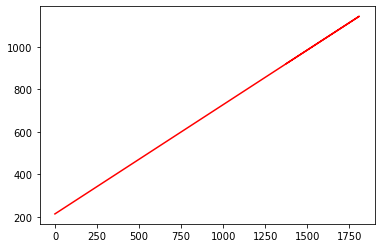

In [8]:
'''PREDICT X and Y and conclude the Concept of having or not a nodule'''
'''Predict X'''
from scipy import stats
#linregress() renvoie plusieurs variables de retour. On s'interessera 
# particulierement au slope et intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(df._x_coordinate,df._y_coordinate)
def predict(x):
   return slope * x + intercept
fitLine = predict(df._x_coordinate)
print("Slope"+str(slope))
print("intercept"+str(intercept))
print("error:"+str(std_err))
plt.plot(df._x_coordinate, fitLine, c='r')

print('MODEL PARAMETERS: Y='+str(slope)+'*X+'+str(intercept))


%%Method 2 : Using sklearn , automated performances check

In [9]:
'''LOAD  AND PREPROCESS TEST DATA '''
import pandas as pd


dataset1=pd.read_csv("./Clinical_Information/CLNDAT_EN.csv",delimiter=";", names=["image_path" , '_age', '_sex', '_x_coordinate','_y_coordinate', '_degree_of_subtlety', '_nodule_size', '_malignant_or_benign','_position', '_diagnosis'])
dataset2=pd.read_csv("./Clinical_Information/CNNDAT_EN.csv",delimiter=";", names=["image_path" , '_age','_x_coordinate','_y_coordinate',  '_sex', 'image_type'])


frames=[dataset1, dataset2]
test_dataset = pd.concat(frames)
test_dataset

,image_path,_age,_sex,_x_coordinate,_y_coordinate,_degree_of_subtlety,_nodule_size,_malignant_or_benign,_position,_diagnosis,image_type
"(JPCLN001.IMG, 5)",15,53,male,1634,692,malignant,l.upper,lobe,lung cancer,NaN,NaN
"(JPCLN002.IMG, 5)",30,78,female,1614,1090,benign,l.upper,lobe(S5),pulmonary he,matoma,NaN
"(JPCLN003.IMG, 5)",30,63,female,1303,447,malignant,l.upper,lobe(S1+2),lung cancer,NaN,NaN
"(JPCLN004.IMG, 5)",14,68,female,606,836,benign,r.upper,lobe,inflammatory,mass,NaN
"(JPCLN005.IMG, 5)",35,73,female,1438,692,malignant,l.upper,lobe(S3),lung cancer,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
88,JPCNN089.IMG,50,male,-1,-1,NaN,NaN,NaN,NaN,NaN,non-nodule
89,JPCNN090.IMG,68,female,-1,-1,NaN,NaN,NaN,NaN,NaN,non-nodule
90,JPCNN091.IMG,81,male,-1,-1,NaN,NaN,NaN,NaN,NaN,non-nodule
91,JPCNN092.IMG,70,female,-1,-1,NaN,NaN,NaN,NaN,NaN,non-nodule


<class 'pandas.core.series.Series'>
MODEL ACCURANCY: 0.41419899516011693
Coefficients: 
 [[0.51386933]]
Mean squared error: 148146.20
Coefficient of determination: 0.42


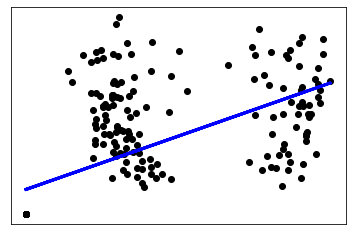

In [11]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score


print(type(df._x_coordinate))
# Split the data into training/testing sets
X_train = df._x_coordinate 
X_test = test_dataset._x_coordinate

# Split the targets into training/testing sets
y_train = df._y_coordinate
y_test = test_dataset._y_coordinate

#Reshaping data
X_train=X_train.values.reshape(-1, 1)


X_test=X_test.values.reshape(-1, 1)
y_train=y_train.values.reshape(-1,1)
y_test=y_test.values.reshape(-1,1)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)
print("MODEL ACCURANCY: "+str(regr.score(X_train,y_train)))

# Make predictions using the testing set
y_pred = regr.predict(X_test)

#print("Predictions")
#print(y_pred)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

Both methods gives the same slope 0.47

Le training a été fait sur un nombre limité d'images du au performances limitées de nos machines.